<a href="https://colab.research.google.com/github/trong-khanh-1109/CS231.M13.KHCL/blob/main/Garbage_Classification_VGG16_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content'
!gdown https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3
# !gdown https://drive.google.com/uc?id=1cexqei_xiWRnw6ne0vyYK5g7LFlc2kbn
# !gdown https://drive.google.com/uc?id=1t_2xCN_iLmbK1O6Fm39UTCB2xYzG2lVg

/content
Downloading...
From: https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3
To: /content/Garbage classification 1.zip
100% 56.7M/56.7M [00:00<00:00, 155MB/s] 


In [ ]:
!unzip '/content/Garbage classification 1.zip'

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


# Import library

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

In [ ]:
FJoin = os.path.join

# Statistics

In [ ]:
train_path = '/content/Garbage classification/train'
validation_path = '/content/Garbage classification/validation'
test_path = '/content/Garbage classification/test'
path = '/content/Garbage classification'

In [ ]:
def ThongKe(arr_link, label_data, name_data):
  tong = 0
  for index, arr in enumerate(arr_link):
    list_img = os.listdir(arr)
    print("Number of data {}: {}".format(label_data[index], len(list_img)))
    tong = tong + len(list_img)
  print("Total of data " + name_data + ": " + str(tong))

In [ ]:
def List(path, name_data):
  print("-------- " + name_data +  " --------")
  label_data = sorted(os.listdir(path))
  arr_link = [FJoin(path, f) for f in sorted(os.listdir(path))]
  ThongKe(arr_link, label_data, name_data)

In [ ]:
List(train_path, 'train')
print('\n\n')
List(validation_path, 'validation')
print('\n\n')
List(test_path, 'test')

-------- train --------
Number of data cardboard: 480
Number of data glass: 480
Number of data metal: 480
Number of data paper: 480
Number of data plastic: 480
Number of data trash: 480
Total of data train: 2880



-------- validation --------
Number of data cardboard: 160
Number of data glass: 160
Number of data metal: 160
Number of data paper: 160
Number of data plastic: 160
Number of data trash: 160
Total of data validation: 960



-------- test --------
Number of data cardboard: 160
Number of data glass: 161
Number of data metal: 159
Number of data paper: 160
Number of data plastic: 160
Number of data trash: 161
Total of data test: 961


# Data preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
        rotation_range = 20, # Dữ liệu được tạo ra sẽ được xoay ngẫu nhiên một góc trong phạm vi +rotation_rangeđến -rotation_range(tính bằng độ)
        width_shift_range = 0.2, # Dịch theo chiều ngang ngẫu nhiên trong một phạm vi nào đó
        height_shift_range = 0.2, # Dịch ảnh theo chiều dọc trong một phạm vi nào đó
        horizontal_flip = True, # lật ảnh ngẫu nhiên theo chiều ngang
        vertical_flip = True, # lật ảnh ngẫu nhiên theo chiều dọc
)

validation_datagen = ImageDataGenerator(
        preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
        rescale = 1./255
)

test_datagen = ImageDataGenerator(
        preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input,
        rescale = 1./255
)

In [ ]:
img_shape = (224, 224, 3)
train_batch_size = 16
val_batch_size = 16

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'sparse',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/validation',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'sparse',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'sparse',
            shuffle=False,)

Found 2880 images belonging to 6 classes.
Found 960 images belonging to 6 classes.
Found 961 images belonging to 6 classes.


In [ ]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Building model VGG16 to extract features

## Pretrained Convolutional Base (VGG16)

In [ ]:
from tensorflow.keras.applications import VGG16
model_VGG16 = VGG16()

553476096/553467096 [==============================] - 8s 0us/step


In [ ]:
# model_VGG16 = VGG16(weights = 'imagenet',
#               include_top = False,
#               input_shape = img_shape)

In [ ]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Fine tunning

In [ ]:
# Freeze the layers except the last 3 layers
for layer in model_VGG16.layers[:-3]:
    layer.trainable = False

# Extract features using VGG16

## Take fully connected layers (FC2)

In [ ]:
from tensorflow.keras.models import Model
layer_fc2 = Model(inputs=model_VGG16.input, outputs=model_VGG16.get_layer('fc2').output)

In [ ]:
layer_fc2.summary()

## Extracting

### Train

In [ ]:
image = np.zeros((1,4096))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(train_generator):
  features_batch = layer_fc2.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* train_generator.batch_size >= train_generator.samples :
    print('stop')
    break
  print(i)

In [ ]:
image_train = image[1:2881,:]
label_train = label[1:2881]

### Validation

In [ ]:
image = np.zeros((1,4096))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(validation_generator):
  features_batch = layer_fc2.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* validation_generator.batch_size >= validation_generator.samples :
    print('stop')
    break

stop


In [ ]:
image_validation = image[1:961,:]
label_validation = label[1:961]

### Test

In [ ]:
image = np.zeros((1,4096))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(test_generator):
  features_batch = layer_fc2.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* test_generator.batch_size >= test_generator.samples :
    print('stop')
    break

stop


In [ ]:
image_test = image[1:962,:]
label_test = label[1:962]

# Train using model SVM

## Function Plot Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load model

In [ ]:
# load the model from disk
# filename = ...
# model_SVM = pickle.load(open(filename, 'rb'))

## Kernel linear

In [ ]:
from sklearn import svm
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(image_train, label_train)

SVC(kernel='linear')

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.80      0.88      0.84       160
       glass       0.64      0.73      0.68       160
       metal       0.64      0.53      0.58       160
       paper       0.72      0.64      0.68       160
     plastic       0.57      0.39      0.46       160
       trash       0.68      0.93      0.78       160

    accuracy                           0.68       960
   macro avg       0.67      0.68      0.67       960
weighted avg       0.67      0.68      0.67       960



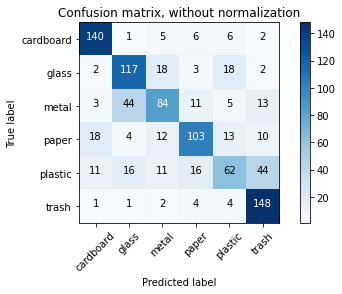

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.70      0.86      0.77       160
       glass       0.64      0.70      0.66       161
       metal       0.59      0.65      0.62       159
       paper       0.68      0.59      0.63       160
     plastic       0.43      0.36      0.39       160
       trash       0.47      0.42      0.44       161

    accuracy                           0.59       961
   macro avg       0.58      0.59      0.59       961
weighted avg       0.58      0.59      0.59       961



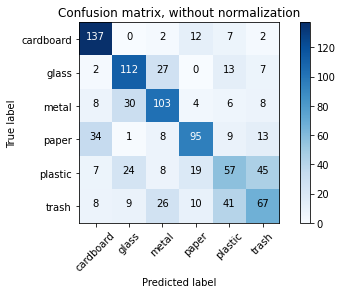

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
#save model

filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/VGG16_SVM/Garbage_Classification_VGG16_SVM_linear_.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

## Kernel rbf

In [ ]:
model_SVM = svm.SVC(kernel='rbf')
model_SVM.fit(image_train, label_train)

SVC()

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.62      0.89      0.73       160
       glass       0.60      0.44      0.51       160
       metal       0.58      0.74      0.65       160
       paper       0.71      0.38      0.50       160
     plastic       0.45      0.31      0.37       160
       trash       0.57      0.75      0.65       160

    accuracy                           0.59       960
   macro avg       0.59      0.59      0.57       960
weighted avg       0.59      0.59      0.57       960



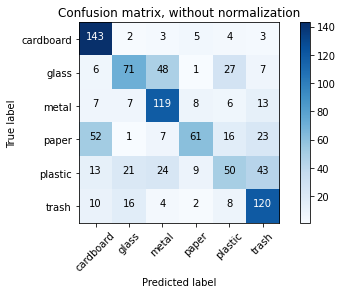

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.56      0.83      0.67       160
       glass       0.63      0.43      0.51       161
       metal       0.51      0.67      0.58       159
       paper       0.77      0.39      0.51       160
     plastic       0.40      0.42      0.41       160
       trash       0.44      0.43      0.44       161

    accuracy                           0.53       961
   macro avg       0.55      0.53      0.52       961
weighted avg       0.55      0.53      0.52       961



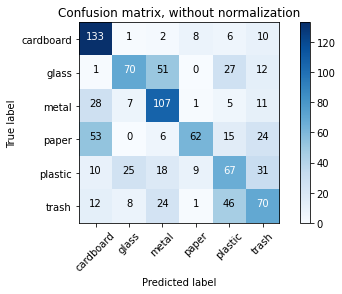

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/VGG16_SVM/Garbage_Classification_VGG16_SVM_rbf.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

## Kernel polynomial

In [ ]:
model_SVM = svm.SVC(kernel='poly')
model_SVM.fit(image_train, label_train)

SVC(kernel='poly')

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.66      0.91      0.77       160
       glass       0.67      0.49      0.56       160
       metal       0.63      0.71      0.67       160
       paper       0.81      0.40      0.54       160
     plastic       0.50      0.38      0.43       160
       trash       0.57      0.86      0.69       160

    accuracy                           0.62       960
   macro avg       0.64      0.62      0.61       960
weighted avg       0.64      0.62      0.61       960



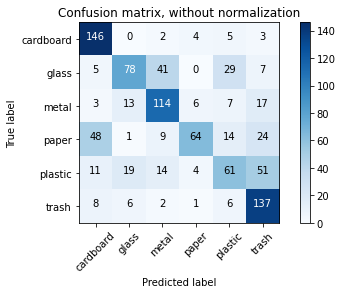

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.61      0.88      0.72       160
       glass       0.65      0.48      0.55       161
       metal       0.54      0.67      0.60       159
       paper       0.86      0.39      0.54       160
     plastic       0.45      0.44      0.45       160
       trash       0.43      0.50      0.47       161

    accuracy                           0.56       961
   macro avg       0.59      0.56      0.55       961
weighted avg       0.59      0.56      0.55       961



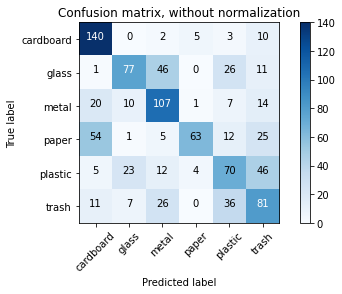

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/VGG16_SVM/Garbage_Classification_VGG16_SVM_poly.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

## Predict an image

In [ ]:
labels = sorted(os.listdir('/content/Garbage classification/test'))

In [ ]:
img = cv2.imread('/content/Garbage classification/test/paper/paper_120.jpg')
img = cv2.resize(img, (224, 224))
img = img.astype('float32')/255
img = img.reshape(1, 224, 224, 3)

In [ ]:
# model = keras.models.load_model('/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/VGG16/GB_vgg16.h5')

In [ ]:
y_pred = model_SVM.predict(img)

In [ ]:
y_pred_label = np.argmax(y_pred, axis=1)
print(labels[y_pred_label[0]])

paper
